In [1]:
import numpy as np
import pandas as pd
import torch

from DeePyMoD_SBL.data import Burgers
from DeePyMoD_SBL.deepymod_torch.library_functions import library_1D_in
from DeePyMoD_SBL.deepymod_torch.DeepMod import DeepMod, DeepModDynamic
from DeePyMoD_SBL.deepymod_torch.output import Tensorboard, progress
from DeePyMoD_SBL.deepymod_torch.losses import reg_loss, mse_loss
from DeePyMoD_SBL.deepymod_torch.training import train
from DeePyMoD_SBL.Lasso import lasso
from DeePyMoD_SBL.deepymod_torch.sparsity import scaling

if torch.cuda.is_available():
    torch.set_default_tensor_type('torch.cuda.FloatTensor')

import matplotlib.pyplot as plt


import time


%load_ext autoreload
%autoreload 2

/opt/conda/lib/python3.6/site-packages/tensorboard/compat/tensorflow_stub/dtypes.py:541: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
/opt/conda/lib/python3.6/site-packages/tensorboard/compat/tensorflow_stub/dtypes.py:542: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
/opt/conda/lib/python3.6/site-packages/tensorboard/compat/tensorflow_stub/dtypes.py:543: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])
/opt/conda/lib/python3.6/site-packages/tensorboard/compat/tensorflow_stub/dtypes.py:544: FutureWa

# useful funcs

In [2]:
import os
from tensorboard.backend.event_processing.event_accumulator import EventAccumulator

def load_tensorboard(path):
    # Assumes one file per folder
    event_file = next(filter(lambda filename: filename[:6] =='events', os.listdir(path)))
    summary_iterator = EventAccumulator(str(path + event_file)).Reload()
    
    tags = summary_iterator.Tags()['scalars']
    steps = np.array([event.step for event in summary_iterator.Scalars(tags[0])])
    data = np.array([[event.value for event in summary_iterator.Scalars(tag)] for tag in tags]).T
    df = pd.DataFrame(data=data, index=steps, columns=tags)
    
    return df

In [3]:
def soft_threshold(x, alpha):
    return torch.max(torch.abs(x) - alpha, torch.zeros_like(x)) * torch.sign(x)

In [4]:
def lasso(X, y, l1, conv_tol=1e-7, w=None):
    L = 2 * torch.symeig(X.T @ X).eigenvalues.max()
    
    if w == None:
        w = torch.zeros((X.shape[1], 1), dtype=torch.float32) # if not given, start with zeros, else do warm restart
        
    t = torch.tensor(1.0)
    z = w
    
    converged=False
    while not converged:
        w_old = w
        t_old = t
        z_old = z
        
        w = soft_threshold(z_old - 2 * X.T @ (X @ z_old - y) / L, l1/L)
        t = (1 + torch.sqrt(1 + 4 * t_old**2))/2
        z = w + (t_old - 1) / t * (w - w_old)
        converged = torch.max(torch.abs(w - w_old)) < conv_tol
    return w

# Making data

In [5]:
x = np.linspace(-2, 5, 75)
t = np.linspace(0.5, 5.0, 25)

x_grid, t_grid = np.meshgrid(x, t, indexing='ij')

In [6]:
dataset = Burgers(0.1, 1.0)

In [7]:
u = dataset.solution(x_grid, t_grid)

In [8]:
X = np.concatenate((t_grid.reshape(-1, 1), x_grid.reshape(-1, 1)), axis=1)
y = u.reshape(-1, 1)

In [9]:
X_train = torch.tensor(X, dtype=torch.float32, requires_grad=True)
y_train = torch.tensor(y, dtype=torch.float32, requires_grad=True)

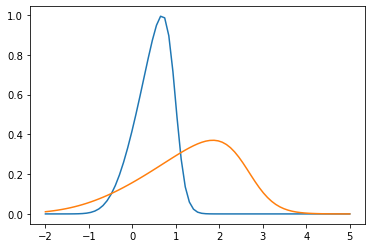

In [10]:
plt.plot(x, u[:, 1])
plt.plot(x, u[:, 24])

# Running new

In [11]:
noise_level = 0.05

In [12]:
X_train = torch.tensor(X, dtype=torch.float32, requires_grad=True)
y_train = torch.tensor(y + noise_level * np.std(y) * np.random.randn(y.size, 1), dtype=torch.float32, requires_grad=True)

In [13]:
config = {'n_in': 2, 'hidden_dims': [30, 30, 30, 30, 30], 'n_out': 1, 'library_function':library_1D_in, 'library_args':{'poly_order':2, 'diff_order': 2}}

In [14]:
model = DeepModDynamic(**config)

In [15]:
optimizer = torch.optim.Adam(model.network_parameters(), betas=(0.99, 0.999), amsgrad=True)

Let's first train it for 10k iterations and see if we can set some terms to zero:

In [16]:
data = X_train
target = y_train
max_iterations = 5000
loss_func_args={'l1':torch.tensor(1e-5), 'conv_tol': torch.tensor(1e-3)}


print('| Iteration | Progress | Time remaining |     Cost |      MSE |      Reg |       L1 |')
for iteration in torch.arange(0, max_iterations + 1):
    # Calculating prediction and library and scaling
    prediction, time_deriv_list, sparse_theta_list, coeff_vector_list, theta = model(data)
    coeff_vector_scaled_list = scaling(coeff_vector_list, sparse_theta_list, time_deriv_list)
        
    # Calculating loss
    loss_reg = reg_loss(time_deriv_list, sparse_theta_list, coeff_vector_list)
    loss_mse = mse_loss(prediction, target)
    loss = torch.sum(loss_reg) + torch.sum(loss_mse)
        
    # Writing
    if iteration % 100 == 0:
        progress(iteration, 0.0, max_iterations, loss.item(), torch.sum(loss_mse).item(), torch.sum(loss_reg).item(), 0.0)
           
    # Optimizer step
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

| Iteration | Progress | Time remaining |     Cost |      MSE |      Reg |       L1 |
       5000    100.00%               0s   1.21e-04   1.06e-04   1.54e-05   0.00e+00 

Now let's see if we can cut some terms already:

In [17]:
model.fit.coeff_vector

[tensor([[-6.4164e-04],
         [-2.0623e-02],
         [ 1.0023e-01],
         [ 8.8985e-02],
         [-9.9753e-01],
         [-6.2859e-02],
         [-2.9010e-01],
         [ 2.4751e-01],
         [ 1.2117e-02]], grad_fn=<MmBackward>)]

In [18]:
coeff_vector_scaled_list[0]

tensor([[-0.0042],
        [-0.0418],
        [ 0.6873],
        [ 0.1385],
        [-1.0194],
        [-0.3210],
        [-0.2569],
        [ 0.1805],
        [ 0.0588]], grad_fn=<MulBackward0>)

In [19]:
_, time_deriv_list, _, _, theta = model(X_train)

In [20]:
with torch.no_grad():
    dt = time_deriv_list[0] / torch.norm(time_deriv_list[0])
    theta_normed = theta / torch.norm(theta, dim=0, keepdim=True)
    w_ini = model.fit.coeff_vector[0].detach()

The least squares solution of the scaled problem:

In [21]:
torch.inverse(theta_normed.T @ theta_normed) @ theta_normed.T @ dt

tensor([[-0.0042],
        [-0.0418],
        [ 0.6873],
        [ 0.1385],
        [-1.0194],
        [-0.3210],
        [-0.2568],
        [ 0.1805],
        [ 0.0588]])

In [22]:
lasso_coeff = lasso(theta_normed, dt, l1=torch.tensor(1e-2), conv_tol=torch.tensor(1e-7))

In [23]:
lasso_coeff

tensor([[ 0.0178],
        [-0.1220],
        [ 0.5782],
        [ 0.0000],
        [-0.8065],
        [-0.0000],
        [-0.0682],
        [-0.0000],
        [-0.0790]])

In [24]:
torch.where(torch.abs(lasso_coeff)> 1e-6)[0]

tensor([0, 1, 2, 4, 6, 8])

In [27]:
data = X_train
target = y_train
max_iterations = 10000
loss_func_args={'l1':torch.tensor(1e-1), 'conv_tol': torch.tensor(1e-7)}


print('| Iteration | Progress | Time remaining |     Cost |      MSE |      Reg |       L1 |')
for iteration in torch.arange(0, max_iterations + 1):
    # Calculating prediction and library and scaling
    prediction, time_deriv_list, sparse_theta_list, coeff_vector_list, theta = model(data)
    coeff_vector_scaled_list = scaling(coeff_vector_list, sparse_theta_list, time_deriv_list)
        
    # Calculating loss
    loss_reg = reg_loss(time_deriv_list, sparse_theta_list, coeff_vector_list)
    loss_mse = mse_loss(prediction, target)
    loss = torch.sum(loss_reg) + torch.sum(loss_mse)
        
    # Writing
    if iteration % 100 == 0:
        progress(iteration, 0.0, max_iterations, loss.item(), torch.sum(loss_mse).item(), torch.sum(loss_reg).item(), 0.0)
           
    # Optimizer step
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()
    
    with torch.no_grad():
        if iteration % 200 == 0:
            with torch.no_grad():
                dt = time_deriv_list[0] / torch.norm(time_deriv_list[0])
                theta_normed = theta / torch.norm(theta, dim=0, keepdim=True)
                lasso_coeff = lasso(theta_normed, dt, l1=loss_func_args['l1'], conv_tol=loss_func_args['conv_tol'])
                model.fit.sparsity_mask = [torch.where(torch.abs(lasso_coeff)> 1e-6)[0]]
                print(lasso_coeff)
                print(model.fit.sparsity_mask)
                

| Iteration | Progress | Time remaining |     Cost |      MSE |      Reg |       L1 |
          0      0.00%               0s   9.57e-05   9.15e-05   4.13e-06   0.00e+00 tensor([[ 0.0000],
        [-0.0583],
        [ 0.5386],
        [-0.0000],
        [-0.8265],
        [ 0.0000],
        [-0.0000],
        [-0.0000],
        [ 0.0000]])
[tensor([1, 2, 4])]
        200      2.00%     77765468160s   1.04e-04   9.37e-05   1.02e-05   0.00e+00 tensor([[-0.0000],
        [-0.0556],
        [ 0.5546],
        [-0.0000],
        [-0.8237],
        [ 0.0000],
        [-0.0000],
        [-0.0000],
        [ 0.0000]])
[tensor([1, 2, 4])]
        400      4.00%     38089207808s   9.99e-05   9.25e-05   7.35e-06   0.00e+00 tensor([[-0.0000],
        [-0.0481],
        [ 0.5569],
        [-0.0000],
        [-0.8312],
        [ 0.0000],
        [-0.0000],
        [-0.0000],
        [ 0.0000]])
[tensor([1, 2, 4])]
        600      6.00%     23805755392s   9.83e-05   9.16e-05   6.70e-06   0.00e+00 te

In [28]:
model.fit.coeff_vector

[tensor([[ 0.0012],
         [ 0.0991],
         [-1.0048]], grad_fn=<MmBackward>)]

In [29]:
coeff_vector_scaled_list[0]

tensor([[ 0.0022],
        [ 0.6393],
        [-0.9405]], grad_fn=<MulBackward0>)

In [48]:
lasso_coeff = lasso(theta_normed, dt, l1=torch.tensor(1e-2), conv_tol=torch.tensor(1e-9))

In [49]:
lasso_coeff

tensor([[ 0.0000],
        [-0.0017],
        [ 0.6319],
        [-0.0000],
        [-0.9303],
        [ 0.0000],
        [-0.0000],
        [-0.0000],
        [ 0.0000]])

In [43]:
sparse_theta_normed = sparse_theta_list[0].detach()
sparse_theta_normed = sparse_theta_normed / torch.norm(sparse_theta_normed, dim=0, keepdim=True)

In [44]:
lasso(sparse_theta_normed, dt, l1=torch.tensor(1e-3), conv_tol=torch.tensor(1e-9))

RuntimeError: CUDA out of memory. Tried to allocate 2.00 MiB (GPU 0; 11.78 GiB total capacity; 7.30 GiB already allocated; 6.25 MiB free; 7.30 GiB reserved in total by PyTorch)

In [45]:
lasso_path = [lasso(sparse_theta_normed, dt, l1=torch.tensor(alpha), conv_tol=torch.tensor(1e-9)).cpu for alpha in np.logspace(-7, 1, 100)]

RuntimeError: CUDA out of memory. Tried to allocate 2.00 MiB (GPU 0; 11.78 GiB total capacity; 7.30 GiB already allocated; 6.25 MiB free; 7.30 GiB reserved in total by PyTorch)

# Analysis

So the basic version worked, which is great news :) Now let's analyse the results a bit, cause its weird it didnt find the right coefficient

In [1]:
prediction, time_deriv_list, sparse_theta_list, coeff_vector_list, theta = model(data)

NameError: name 'model' is not defined

In [353]:
u_inf = prediction.cpu().detach().numpy().reshape(x_grid.shape)

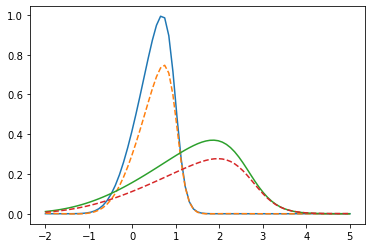

In [354]:
plt.plot(x, u[:, 1])
plt.plot(x, u_inf[:, 1], '--')
plt.plot(x, u[:, 24])
plt.plot(x, u_inf[:, 24], '--')

In [324]:
theta_inf = theta.cpu().detach().numpy()
dt_inf = time_deriv_list[0].cpu().detach().numpy()

In [325]:
np.linalg.lstsq(sparse_theta_list[0].cpu().detach().numpy(), dt_inf, rcond=None)

(array([[ 0.09960804],
        [-1.4153868 ]], dtype=float32),
 array([0.00159913], dtype=float32),
 2,
 array([36.12801  ,  3.7353694], dtype=float32))

In [326]:
theta_true = dataset.library(x_grid.reshape(-1, 1), t_grid.reshape(-1, 1)).reshape(-1, 3, 4)[:, :, :3].reshape(-1, 9)
dt_true = dataset.time_deriv(x_grid.reshape(-1, 1), t_grid.reshape(-1, 1))

In [327]:
np.mean((dt_inf-dt_true)**2)

0.0014109271428993874

In [302]:
np.max((dt_inf - dt_true)**2)

0.38432627453223484

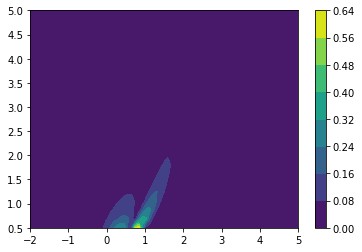

In [319]:
plt.contourf(x_grid, t_grid, np.abs((dt_inf-dt_true).reshape(x_grid.shape)))
plt.colorbar()

In [265]:
np.mean((theta_true - theta_inf)**2, axis=0)

array([0.00000000e+00, 2.11861354e-05, 1.99658989e-03, 5.48178753e-07,
       5.59031682e-06, 6.85367445e-04, 2.86565209e-07, 3.14908373e-06,
       4.70344883e-04])

Which is fairly high for the diffusion component...

In [266]:
theta_true[:, 2] - theta_inf[:, 2]

array([ 0.00347116,  0.0012011 , -0.00070819, ...,  0.00168181,
        0.00161378,  0.00127247])

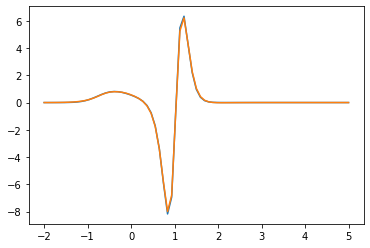

In [282]:
frame = 1
plt.plot(x, theta_true[:, 2].reshape(x_grid.shape)[:, frame])
plt.plot(x, theta_inf[:, 2].reshape(x_grid.shape)[:, frame])

In [280]:
np.mean((theta_true[:, 2].reshape(x_grid.shape) - theta_inf[:, 2].reshape(x_grid.shape))**2, axis=0)

array([4.54030913e-02, 2.10957736e-03, 4.79374676e-04, 2.21865371e-04,
       1.66019334e-04, 1.79721151e-04, 2.00113516e-04, 1.99965630e-04,
       1.77247817e-04, 1.42161526e-04, 1.06532573e-04, 7.81903511e-05,
       5.97654154e-05, 5.00016960e-05, 4.58266524e-05, 4.40672353e-05,
       4.24195137e-05, 3.97275916e-05, 3.58080748e-05, 3.10876286e-05,
       2.62524712e-05, 2.19930031e-05, 1.88837741e-05, 1.73508220e-05,
       1.77028056e-05])

Ah so maybe it's to sharp?

What if we fit and skip the first two frames:

In [290]:
sparse_theta = sparse_theta_list[0].cpu().detach().numpy()

sparse_theta_fit = sparse_theta.reshape((*x_grid.shape, 2))[:, 2:, :].reshape(-1, 2)
dt_fit = dt_inf.reshape(x_grid.shape)[:, 2:].reshape(-1, 1)

In [291]:
np.linalg.lstsq(sparse_theta_fit, dt_fit, rcond=None)

(array([[ 0.09933005],
        [-1.4173105 ]], dtype=float32),
 array([0.00166264], dtype=float32),
 2,
 array([22.394403 ,  2.2797236], dtype=float32))

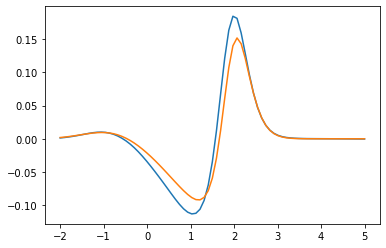

In [318]:
frame = 10
plt.plot(x, dt_inf.reshape(x_grid.shape)[:, frame])
plt.plot(x, dt_true.reshape(x_grid.shape)[:, frame])

Thats weird...

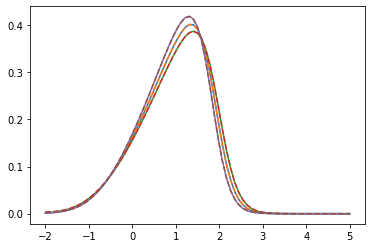

In [330]:
frame = 10

plt.plot(x, u[:, frame])
plt.plot(x, u_inf[:, frame], '--')

plt.plot(x, u[:, frame+1])
plt.plot(x, u_inf[:, frame+1], '--')

plt.plot(x, u[:, frame-1])
plt.plot(x, u_inf[:, frame-1], '--')

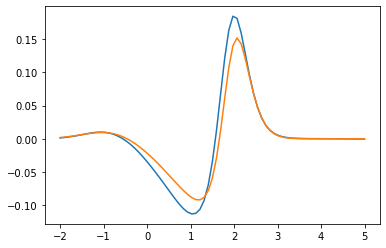

In [331]:
plt.plot(x, dt_inf.reshape(x_grid.shape)[:, frame])
plt.plot(x, dt_true.reshape(x_grid.shape)[:, frame])

In [334]:
u_inf.shape

(75, 25)

array([[-3.8487117e-03, -3.2537777e-03, -1.7883381e-03, ...,
         2.1198194e-03,  2.1108787e-03,  2.1008651e-03],
       [-3.3885639e-03, -2.7466614e-03, -1.2353659e-03, ...,
         2.4203856e-03,  2.3516417e-03,  2.3120244e-03],
       [-2.8107166e-03, -2.1185477e-03, -5.5901211e-04, ...,
         2.6552279e-03,  2.5275152e-03,  2.4611950e-03],
       ...,
       [-3.6279359e-04, -1.3089180e-04,  5.0107639e-05, ...,
         6.1186153e-04,  8.4801513e-04,  1.0120074e-03],
       [-4.0094057e-04, -1.7726421e-04, -1.3113022e-06, ...,
         6.4063072e-04,  8.0251694e-04,  9.2005730e-04],
       [-4.3567023e-04, -2.2037824e-04, -5.0902367e-05, ...,
         6.9276494e-04,  7.9977512e-04,  8.8318187e-04]], dtype=float32)

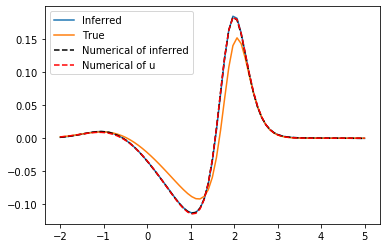

In [344]:
frame = 10
plt.plot(x, dt_inf.reshape(x_grid.shape)[:, frame], label='Inferred')
plt.plot(x, dt_true.reshape(x_grid.shape)[:, frame], label='True')
plt.plot(x, np.gradient(u_inf, t, axis=1)[:, frame], 'k--', label='Numerical of inferred')

plt.plot(x, np.gradient(u, t, axis=1)[:, frame], 'r--', label='Numerical of u')

plt.legend()

Alright so the problem is the time derivative